#**ANALISE DE DADOS DE CASOS DE DENGUE NO BRASIL EM 2024**

*Fonte: https://opendatasus.saude.gov.br/dataset/arboviroses-dengue*

**Explorando dados históricos**

In [46]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

print("Montando o Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive montado com sucesso.\n")
except Exception as e:
    print(f"Erro ao montar o Google Drive: {e}")
    raise Exception("Não foi possível montar o Google Drive.")

caminho_da_pasta = '/content/drive/MyDrive/dados_dengue/'

arquivos_para_processar = []
for i in range(15, 26):
    ano_str = str(i).zfill(2)
    nome_arquivo = f"DENGBR{ano_str}.csv"
    caminho_completo = os.path.join(caminho_da_pasta, nome_arquivo)
    arquivos_para_processar.append(caminho_completo)

# Dicionário de Estados
estado_map = {
    11: "Rondônia", 12: "Acre", 13: "Amazonas", 14: "Roraima", 15: "Pará",
    16: "Amapá", 17: "Tocantins",
    21: "Maranhão", 22: "Piauí", 23: "Ceará", 24: "Rio Grande do Norte",
    25: "Paraíba", 26: "Pernambuco", 27: "Alagoas", 28: "Sergipe", 29: "Bahia",
    31: "Minas Gerais", 32: "Espírito Santo", 33: "Rio de Janeiro", 35: "São Paulo",
    41: "Paraná", 42: "Santa Catarina", 43: "Rio Grande do Sul",
    50: "Mato Grosso do Sul", 51: "Mato Grosso", 52: "Goiás", 53: "Distrito Federal"
}

# Definições das colunas e chunks
CODIGO_OBITO_AGRAVO = 2.0
COLUNA_OBITO = 'EVOLUCAO'
COLUNA_ESTADO = 'SG_UF'
COLUNA_SEXO = 'CS_SEXO'
TAMANHO_DO_CHUNK = 100000

# Dicionários para armazenar os resultados
resultados_timeseries = {}
resultados_mapa = {}
resultados_sexo_2024 = {'M': {'total_casos': 0, 'total_obitos': 0},
                        'F': {'total_casos': 0, 'total_obitos': 0},
                        'I': {'total_casos': 0, 'total_obitos': 0}}

print(f"Iniciando a agregação de dados de {len(arquivos_para_processar)} arquivos...")


print("--- ETAPA 1: Processando 2015-2025 para tabelas de série temporal e mapa ---")
for caminho_arquivo in arquivos_para_processar:
    nome_arquivo = os.path.basename(caminho_arquivo)
    try:
        ano_str = nome_arquivo[6:8]
        ano = int(f"20{ano_str}")
        print(f"\n--- Processando arquivo: {nome_arquivo} (Ano: {ano}) ---")
    except Exception as e:
        print(f"Erro ao extrair o ano de {nome_arquivo}. Pulando... {e}")
        continue

    if ano not in resultados_timeseries:
        resultados_timeseries[ano] = {'total_casos': 0, 'total_obitos': 0}

    chunk_num = 1

    try:
        if not os.path.exists(caminho_arquivo):
            print(f"AVISO: Arquivo não encontrado: {caminho_arquivo}. Pulando este ano.")
            continue

        with pd.read_csv(
            caminho_arquivo,
            sep=',',
            encoding='latin1',
            chunksize=TAMANHO_DO_CHUNK,
            usecols=[COLUNA_OBITO, COLUNA_ESTADO],
            dtype={COLUNA_OBITO: 'float64', COLUNA_ESTADO: 'float64'}
        ) as reader:

            for chunk in reader:
                # 1. Contagem por Ano (Casos e Óbitos)
                casos_no_chunk = chunk.shape[0]
                obitos_chunk = chunk[chunk[COLUNA_OBITO] == CODIGO_OBITO_AGRAVO]
                obitos_no_chunk = obitos_chunk.shape[0]

                resultados_timeseries[ano]['total_casos'] += casos_no_chunk
                resultados_timeseries[ano]['total_obitos'] += obitos_no_chunk

                # 2. Contagem por Estado (Apenas Óbitos)
                obitos_por_estado_chunk = obitos_chunk.groupby(COLUNA_ESTADO).size()

                for estado_cod, contagem in obitos_por_estado_chunk.items():
                    if pd.notna(estado_cod):
                        estado_cod_int = int(estado_cod)
                        if estado_cod_int not in resultados_mapa:
                            resultados_mapa[estado_cod_int] = 0
                        resultados_mapa[estado_cod_int] += contagem

                if chunk_num % 10 == 0:
                     print(f"  ...processado chunk {chunk_num} ({casos_no_chunk:,} casos, {obitos_no_chunk} óbitos)")
                chunk_num += 1

        print(f"Processamento de {ano} concluído.")

    except Exception as e:
        print(f"ERRO ao processar o arquivo {caminho_arquivo}: {e}")

print("\nAgregação da Etapa 1 concluída.")


print("\n--- ETAPA 2: Processando 2024 para tabela de letalidade por sexo ---")
caminho_2024 = os.path.join(caminho_da_pasta, 'DENGBR24.csv')
chunk_num = 1

try:
    if not os.path.exists(caminho_2024):
        print(f"AVISO: Arquivo não encontrado: {caminho_2024}.")
    else:
        with pd.read_csv(
            caminho_2024,
            sep=',',
            encoding='latin1',
            chunksize=TAMANHO_DO_CHUNK,
            usecols=[COLUNA_OBITO, COLUNA_SEXO],
            dtype={COLUNA_OBITO: 'float64', COLUNA_SEXO: 'object'}
        ) as reader:

            for chunk in reader:
                # 1. Conta Total de Casos por Sexo
                casos_sexo_chunk = chunk[COLUNA_SEXO].value_counts()
                for sexo, contagem in casos_sexo_chunk.items():
                    if sexo in resultados_sexo_2024:
                        resultados_sexo_2024[sexo]['total_casos'] += contagem

                # 2. Conta Total de Óbitos por Sexo
                obitos_chunk = chunk[chunk[COLUNA_OBITO] == CODIGO_OBITO_AGRAVO]
                obitos_sexo_chunk = obitos_chunk[COLUNA_SEXO].value_counts()
                for sexo, contagem in obitos_sexo_chunk.items():
                    if sexo in resultados_sexo_2024:
                        resultados_sexo_2024[sexo]['total_obitos'] += contagem

                if chunk_num % 10 == 0:
                     print(f"  ...processado chunk {chunk_num} de 2024")
                chunk_num += 1

    print("Agregação da Etapa 2 concluída.")

except Exception as e:
    print(f"ERRO ao processar o arquivo {caminho_2024}: {e}")

print("\n" + "="*80)
print("RELATÓRIO FINAL: Tabelas de Dados Agregados")
print("="*80)


print("\nTABELA 1 e 2: Total de Casos e Óbitos por Ano (2015-2025)")
if not resultados_timeseries:
    print("Nenhum dado agregado.")
    df_agregado_por_ano = pd.DataFrame(columns=['ano', 'total_casos', 'total_obitos'])
else:
    df_agregado_por_ano = pd.DataFrame.from_dict(resultados_timeseries, orient='index')
    df_agregado_por_ano = df_agregado_por_ano.reset_index().rename(columns={'index': 'ano'})
    df_agregado_por_ano = df_agregado_por_ano[df_agregado_por_ano['total_casos'] > 0]
    display(df_agregado_por_ano)


print("\nTABELA 3: Total de Óbitos por Estado (Soma 2015-2025)")
if not resultados_mapa:
    print("Nenhum dado agregado.")
    df_obitos_por_estado = pd.DataFrame(columns=['codigo_uf', 'nome_estado', 'total_obitos'])
else:
    df_obitos_por_estado = pd.DataFrame(list(resultados_mapa.items()), columns=['codigo_uf', 'total_obitos'])
    df_obitos_por_estado['nome_estado'] = df_obitos_por_estado['codigo_uf'].map(estado_map)
    # Reordenar colunas
    df_obitos_por_estado = df_obitos_por_estado[['codigo_uf', 'nome_estado', 'total_obitos']]
    df_obitos_por_estado = df_obitos_por_estado.sort_values(by='total_obitos', ascending=False)
    display(df_obitos_por_estado)


print("\nTABELA 4: Letalidade por Sexo em 2024")
if not resultados_sexo_2024:
    print("Nenhum dado agregado.")
    df_letalidade_sexo_2024 = pd.DataFrame(columns=['sexo', 'total_casos', 'total_obitos', 'letalidade_%'])
else:
    df_letalidade_sexo_2024 = pd.DataFrame.from_dict(resultados_sexo_2024, orient='index')
    df_letalidade_sexo_2024 = df_letalidade_sexo_2024.reset_index().rename(columns={'index': 'sexo'})

    # Calcular a letalidade
    df_letalidade_sexo_2024['letalidade_%'] = (
        (df_letalidade_sexo_2024['total_obitos'] / df_letalidade_sexo_2024['total_casos']) * 100
    )
    # Filtra apenas os sexos válidos (M e F)
    df_letalidade_sexo_2024 = df_letalidade_sexo_2024[df_letalidade_sexo_2024['sexo'].isin(['M', 'F'])]
    display(df_letalidade_sexo_2024)

print("\n--- Processamento concluído ---")

Montando o Google Drive...
Mounted at /content/drive
Google Drive montado com sucesso.

Iniciando a agregação de dados de 11 arquivos...
--- ETAPA 1: Processando 2015-2025 para tabelas de série temporal e mapa ---

--- Processando arquivo: DENGBR15.csv (Ano: 2015) ---
  ...processado chunk 10 (100,000 casos, 25 óbitos)
  ...processado chunk 20 (100,000 casos, 62 óbitos)
Processamento de 2015 concluído.

--- Processando arquivo: DENGBR16.csv (Ano: 2016) ---
  ...processado chunk 10 (100,000 casos, 50 óbitos)
  ...processado chunk 20 (100,000 casos, 35 óbitos)
Processamento de 2016 concluído.

--- Processando arquivo: DENGBR17.csv (Ano: 2017) ---
Processamento de 2017 concluído.

--- Processando arquivo: DENGBR18.csv (Ano: 2018) ---
Processamento de 2018 concluído.

--- Processando arquivo: DENGBR19.csv (Ano: 2019) ---
  ...processado chunk 10 (100,000 casos, 31 óbitos)
  ...processado chunk 20 (100,000 casos, 30 óbitos)
Processamento de 2019 concluído.

--- Processando arquivo: DENGBR20

,ano,total_casos,total_obitos
0,2015,2398060,1009
1,2016,2298020,741
2,2017,518483,208
3,2018,478880,223
4,2019,2261956,858
5,2020,1495117,583
6,2021,1010359,277
7,2022,1393877,1051
8,2023,1508653,1096
9,2024,6434137,6270



TABELA 3: Total de Óbitos por Estado (Soma 2015-2025)


,codigo_uf,nome_estado,total_obitos
14,35,São Paulo,4901
6,31,Minas Gerais,2188
18,41,Paraná,1439
8,52,Goiás,1204
9,53,Distrito Federal,653
25,42,Santa Catarina,553
24,43,Rio Grande do Sul,467
19,33,Rio de Janeiro,376
4,29,Bahia,355
11,50,Mato Grosso do Sul,244



TABELA 4: Letalidade por Sexo em 2024


,sexo,total_casos,total_obitos,letalidade_%
0,M,2915347,3085,0.105819
1,F,3508916,3181,0.090655



--- Processamento concluído ---


##**Ánalises Gráficas**

In [51]:
import plotly.express as px
import pandas as pd

fig = px.choropleth(
    df_obitos_por_estado,
    geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
    featureidkey="properties.name",
    locations="nome_estado",
    color="total_obitos",
    color_continuous_scale="YlOrRd",
    title="Total de Óbitos por Dengue por Estado (Soma 2015-2025)",
)

fig.update_geos(fitbounds="locations", visible=False)

fig.update_layout(
    width=800,
    height=600,
    title_font_size=18,
    margin={"r":0, "t":50, "l":0, "b":10},
    coloraxis_colorbar=dict(
        title="Óbitos",
        orientation="h",
        yanchor="bottom",
        y=-0.1,
        xanchor="center",
        x=0.5,
        len=0.5,
        thickness=5,
        ticklen=3,
        tickfont=dict(size=12)
    )
)

fig.show()


#MACHINE LEARNING

##Importações e Configurações

In [2]:
import re, warnings, os, fnmatch
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

SEED = 42
TEST_SIZE = 0.30

MAX_MISSING = 0.80
MAX_CARD_CAT_INT = 30

# Alvo (Sinan): 1=cura, 2=óbito pelo agravo (classe positiva)
TARGET = 'evolucao'
np.random.seed(SEED)


##Funções Auxiliares

In [3]:
def parse_idade(nu_idade_n):
    """Converte NU_IDADE_N (1=hora, 2=dia, 3=mês, 4=ano; últimos 3 dígitos=valor) em anos."""
    if pd.isna(nu_idade_n):
        return np.nan
    s = str(int(nu_idade_n)).zfill(4)
    t, v = s[0], int(s[1:])
    if t == '4': return float(v)
    if t == '3': return float(v)/12.0
    if t == '2': return float(v)/365.25
    if t == '1': return float(v)/(365.25*24.0)
    return np.nan

def infer_types(df, max_card_int=MAX_CARD_CAT_INT):
    """Detecta automaticamente colunas categóricas e numéricas (pós-limpeza)."""
    cat_cols, num_cols = [], []
    for c in df.columns:
        dt = df[c].dtype
        if str(dt) in ('object','category') or str(dt) == 'bool':
            cat_cols.append(c)
        elif np.issubdtype(dt, np.integer):
            (cat_cols if df[c].nunique(dropna=True) <= max_card_int else num_cols).append(c)
        elif np.issubdtype(dt, np.floating):
            num_cols.append(c)
        else:
            cat_cols.append(c)
    return cat_cols, num_cols

def drop_by_patterns(df, patterns, protected=None):
    """Descarta colunas cujos nomes casem com quaisquer regex em patterns (protege 'protected')."""
    protected = set(protected or [])
    to_drop = [c for c in df.columns if c not in protected and any(re.search(p, c, re.I) for p in patterns)]
    return df.drop(columns=to_drop, errors='ignore'), to_drop


In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive montado em /content/drive")
except Exception as e:
    print("Drive já está montado:", repr(e))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive montado em /content/drive


##Leitura + detecção automática do alvo + amostragem estratificada

In [3]:
import os, csv, gc, math, re, time, unicodedata
import pandas as pd
import numpy as np

dengue_24 = '/content/drive/MyDrive/dados_dengue/DENGBR24.csv'
SEP = ','
ENC = 'latin1'
CHUNK = 250_000
NEG_POS_RATIO = 3          # quantas curas (classe 1) por óbito (classe 2)
MAX_TOTAL_ROWS = 1_200_000 # teto da amostra (tenho pouca capacidade de processamento)

if not os.path.exists(dengue_24):
    raise FileNotFoundError(f"Arquivo não encontrado: {dengue_24}")

print(f"Lendo (detecção do alvo + amostragem por chunks): {dengue_24}")

# normalização de nomes
def _norm(s: str) -> str:
    s = unicodedata.normalize('NFKD', str(s))
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    s = re.sub(r'[^a-z0-9_]+', '', s)
    return s

try:
    header_df = pd.read_csv(dengue_24, sep=SEP, encoding=ENC, engine='c', nrows=0, low_memory=True)
except Exception:
    header_df = pd.read_csv(dengue_24, sep=SEP, encoding=ENC, engine='python', nrows=0, low_memory=False)

orig_cols = list(header_df.columns)
norm_map = {_norm(c): c for c in orig_cols}


cands_norm = [k for k in norm_map.keys() if k.startswith('evoluc')]
if not cands_norm:

    cands_norm = [k for k in norm_map.keys() if 'evolu' in k]

if not cands_norm:
    raise RuntimeError(
        "Não encontrei a coluna de evolução (óbito/cura). "
        f"Primeiras colunas do CSV: {orig_cols[:20]}"
    )

cands_norm.sort(key=len)
TARGET_COL = norm_map[cands_norm[0]]
print(f"Coluna alvo detectada: '{TARGET_COL}' (normalizado='{cands_norm[0]}')")

print(">> Passo A: contando classes (apenas coluna do alvo)...")
start = time.time()
pos_total = 0  # evolucao == 2
neg_total = 0  # evolucao == 1

for i, ch in enumerate(pd.read_csv(
    dengue_24,
    sep=SEP,
    encoding=ENC,
    engine='c',
    chunksize=CHUNK,
    usecols=[TARGET_COL],
    low_memory=True
), start=1):
    ch = ch[ch[TARGET_COL].isin([1, 2])]
    vc = ch[TARGET_COL].value_counts()
    neg_total += int(vc.get(1, 0))
    pos_total += int(vc.get(2, 0))
    if i % 10 == 0:
        print(f"... {i} chunks | curas={neg_total:,} | óbitos={pos_total:,}")

dur = time.time() - start
print(f"Contagem concluída em {dur:.1f}s → curas={neg_total:,} | óbitos={pos_total:,}")
if pos_total == 0:
    raise RuntimeError(f"Nenhum registro com {TARGET_COL} == 2 (óbito por agravo). Verifique o CSV.")

target_pos = pos_total
target_neg = min(neg_total, NEG_POS_RATIO * target_pos)

if target_pos + target_neg > MAX_TOTAL_ROWS:
    target_neg = max(0, MAX_TOTAL_ROWS - target_pos)

print(f"Plano: manter óbitos={target_pos:,} | amostrar curas={target_neg:,} "
      f"(ratio={NEG_POS_RATIO}:1, teto={MAX_TOTAL_ROWS:,})")

print(">> Passo B: construindo amostra estratificada (chunks)...")
start = time.time()
amostras = []
kept_pos = 0
kept_neg = 0
p_keep_neg = (target_neg / neg_total) if neg_total > 0 else 0.0
rng = np.random.default_rng(42)

for i, ch in enumerate(pd.read_csv(
    dengue_24,
    sep=SEP,
    encoding=ENC,
    engine='c',
    chunksize=CHUNK,
    low_memory=True,
    memory_map=True
), start=1):

    ch = ch[ch[TARGET_COL].isin([1, 2])]

    ch_pos = ch[ch[TARGET_COL] == 2]
    ch_neg = ch[ch[TARGET_COL] == 1]

    if kept_pos < target_pos and not ch_pos.empty:
        faltam_pos = target_pos - kept_pos
        if len(ch_pos) > faltam_pos:
            ch_pos = ch_pos.iloc[:faltam_pos]
        amostras.append(ch_pos)
        kept_pos += len(ch_pos)

    if kept_neg < target_neg and not ch_neg.empty and p_keep_neg > 0:
        m = int(round(len(ch_neg) * p_keep_neg))
        if m > 0:
            idx = rng.choice(len(ch_neg), size=min(m, len(ch_neg)), replace=False)
            sub = ch_neg.iloc[idx]
            faltam_neg = target_neg - kept_neg
            if len(sub) > faltam_neg:
                sub = sub.iloc[:faltam_neg]
            amostras.append(sub)
            kept_neg += len(sub)

    if i % 5 == 0:
        print(f"... chunk {i} | curas={kept_neg:,}/{target_neg:,} | óbitos={kept_pos:,}/{target_pos:,}")

    if kept_pos >= target_pos and kept_neg >= target_neg:
        print("Alvos atingidos; encerrando leitura.")
        break

df = pd.concat(amostras, ignore_index=True)
del amostras
gc.collect()
dur = time.time() - start
print(f"Amostra construída: linhas={len(df):,} | colunas={df.shape[1]} | tempo={dur:.1f}s")

# otimização de tipos para reduzir RAM
print(">> Passo C: otimizando dtypes...")
for c in df.columns:
    if c == TARGET_COL:
        continue
    col = df[c]
    if pd.api.types.is_integer_dtype(col):
        df[c] = pd.to_numeric(col, downcast='integer')
    elif pd.api.types.is_float_dtype(col):
        df[c] = pd.to_numeric(col, downcast='float')
    elif pd.api.types.is_object_dtype(col):
        nun = col.nunique(dropna=True)
        if 0 < nun <= 50:
            df[c] = col.astype('category')
print("Dtypes otimizados.")

# Resumos
print("\nShape final da AMOSTRA:", df.shape)
print("Algumas colunas:", list(df.columns)[:20])
print("\nAmostra (5 linhas):")
print(df.head(5).to_string())

print("\nDistribuição da amostra — alvo:")
print(df[TARGET_COL].value_counts().to_string())
print("\nProporções:")
print(df[TARGET_COL].value_counts(normalize=True).round(4).to_string())

if TARGET_COL != 'evolucao':
    if 'evolucao' in df.columns and TARGET_COL != 'evolucao':
        if df['evolucao'].equals(df[TARGET_COL]):
            df.drop(columns=['evolucao'], inplace=True)
    df.rename(columns={TARGET_COL: 'evolucao'}, inplace=True)
    print(f"\nAlias criado: coluna '{TARGET_COL}' renomeada para 'evolucao' para manter compatibilidade.")


Lendo (detecção do alvo + amostragem por chunks): /content/drive/MyDrive/dados_dengue/DENGBR24.csv
Coluna alvo detectada: 'EVOLUCAO' (normalizado='evolucao')
>> Passo A: contando classes (apenas coluna do alvo)...
... 10 chunks | curas=1,890,732 | óbitos=2,283
... 20 chunks | curas=3,980,484 | óbitos=4,860
Contagem concluída em 32.7s → curas=5,209,641 | óbitos=6,270
Plano: manter óbitos=6,270 | amostrar curas=18,810 (ratio=3:1, teto=1,200,000)
>> Passo B: construindo amostra estratificada (chunks)...


/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (22,44,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46,101) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(


... chunk 5 | curas=3,288/18,810 | óbitos=1,340/6,270


/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(


... chunk 10 | curas=6,826/18,810 | óbitos=2,283/6,270


/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (22,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(


... chunk 15 | curas=10,563/18,810 | óbitos=3,518/6,270


/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (22,44,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (22,44,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(


... chunk 20 | curas=14,372/18,810 | óbitos=4,860/6,270


/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(
/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(


... chunk 25 | curas=18,241/18,810 | óbitos=6,086/6,270


/tmp/ipython-input-1348053743.py:102: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, ch in enumerate(pd.read_csv(


Alvos atingidos; encerrando leitura.
Amostra construída: linhas=25,080 | colunas=121 | tempo=63.0s
>> Passo C: otimizando dtypes...
Dtypes otimizados.

Shape final da AMOSTRA: (25080, 121)
Algumas colunas: ['TP_NOT', 'ID_AGRAVO', 'DT_NOTIFIC', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'DT_SIN_PRI', 'SEM_PRI', 'ANO_NASC', 'NU_IDADE_N', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF', 'ID_MN_RESI', 'ID_RG_RESI']

Amostra (5 linhas):
   TP_NOT ID_AGRAVO  DT_NOTIFIC  SEM_NOT  NU_ANO  SG_UF_NOT  ID_MUNICIP  ID_REGIONA  ID_UNIDADE  DT_SIN_PRI  SEM_PRI  ANO_NASC  NU_IDADE_N CS_SEXO  CS_GESTANT  CS_RACA  CS_ESCOL_N  SG_UF  ID_MN_RESI  ID_RG_RESI  ID_PAIS   DT_INVEST ID_OCUPA_N  FEBRE  MIALGIA  CEFALEIA  EXANTEMA  VOMITO  NAUSEA  DOR_COSTAS  CONJUNTVIT  ARTRITE  ARTRALGIA  PETEQUIA_N  LEUCOPENIA  LACO  DOR_RETRO  DIABETES  HEMATOLOG  HEPATOPAT  RENAL  HIPERTENSA  ACIDO_PEPT  AUTO_IMUNE DT_CHIK_S1 DT_CHIK_S2 DT_PRNT  RES_CHIKS1  RES_CHIKS2  RESUL_PRNT 

In [4]:
for c in df.columns:
    if c != 'evolucao' and df[c].dtype == 'object':
        nun = df[c].nunique(dropna=True)
        if 0 < nun <= 50:
            df[c] = df[c].astype('category')
print("Tipagem categórica leve aplicada.")


Tipagem categórica leve aplicada.


##Definição do alvo, binarização e conversão de idade em anos

In [5]:
import re
import numpy as np
import pandas as pd

# 1) Garantias mínimas
if 'df' not in globals():
    raise RuntimeError("O DataFrame 'df' não está em memória. Rode o BLOCO 2 antes.")
if 'evolucao' not in df.columns:
    raise RuntimeError("Coluna-alvo 'evolucao' não encontrada. Assegure o alias no BLOCO 2.")

# 2) Binarização do alvo (1=cura, 2=óbito por agravo)
#    Mantém somente registros com 1 ou 2 e cria y (1 = óbito, 0 = cura)
df = df[df['evolucao'].isin([1, 2, 1.0, 2.0])].copy()
df['y'] = (df['evolucao'].astype(float) == 2.0).astype(int)

# 3) Função para converter NU_IDADE_N em anos
#    Formato clássico SINAN: 1=hora, 2=dia, 3=mês, 4=ano (3 dígitos finais = valor)
def parse_idade_nu(valor):
    if pd.isna(valor):
        return np.nan
    try:
        s = str(int(float(valor))).zfill(4)
    except Exception:
        return np.nan
    tipo, v = s[0], int(s[1:])
    if   tipo == '4': return float(v)                 # anos
    elif tipo == '3': return float(v) / 12.0          # meses → anos
    elif tipo == '2': return float(v) / 365.25        # dias → anos
    elif tipo == '1': return float(v) / (365.25*24.0) # horas → anos
    else: return np.nan

# 4) Construção de idade_anos
col_idade_n = None
for c in df.columns:
    if re.fullmatch(r'nu_idade_n', c, flags=re.IGNORECASE):
        col_idade_n = c
        break

if col_idade_n is not None:
    df['idade_anos'] = df[col_idade_n].apply(parse_idade_nu)
else:

    candidatos = [c for c in df.columns if re.search(r'idade', c, flags=re.IGNORECASE)]
    if candidatos:

        cand = sorted(candidatos, key=lambda x: df[x].isna().mean())[0]
        df['idade_anos'] = pd.to_numeric(df[cand], errors='coerce')
        print(f"[Aviso] NU_IDADE_N não encontrada. Usando coluna '{cand}' como idade (anos) por fallback.")
    else:
        df['idade_anos'] = np.nan
        print("[Aviso] Não foi possível determinar coluna de idade; 'idade_anos' ficou vazia.")

# 5) Imputação simples (mediana) — apenas para garantir ausência de NaN
med_idade = df['idade_anos'].median(skipna=True)
if pd.notna(med_idade):
    df['idade_anos'] = df['idade_anos'].fillna(med_idade)

# 6) Resumos no terminal
print("Distribuição do alvo (y = 1 óbito / 0 cura):")
print(df['y'].value_counts(dropna=False).to_string())

print("\nProporções do alvo:")
print(df['y'].value_counts(normalize=True).round(4).to_string())

print(f"\nIdade (anos) — mediana imputada: {med_idade:.2f}" if pd.notna(med_idade) else "\nIdade (anos) — sem mediana disponível.")
print("\nAmostra (5 linhas) com colunas-chave:")
cols_show = [c for c in ['evolucao', 'y', col_idade_n if col_idade_n else None, 'idade_anos'] if c]
print(df[cols_show].head(5).to_string())


Distribuição do alvo (y = 1 óbito / 0 cura):
y
0    18810
1     6270

Proporções do alvo:
y
0    0.75
1    0.25

Idade (anos) — mediana imputada: 42.00

Amostra (5 linhas) com colunas-chave:
   evolucao  y  NU_IDADE_N  idade_anos
0       2.0  1        4057        57.0
1       2.0  1        4088        88.0
2       2.0  1        4042        42.0
3       2.0  1        4056        56.0
4       2.0  1        4025        25.0


##Limpeza de dados

In [6]:
import re
import numpy as np
import pandas as pd

# Garantias mínimas
if 'df' not in globals():
    raise RuntimeError("O DataFrame 'df' não está em memória. Rode os blocos anteriores.")
if 'y' not in df.columns or 'evolucao' not in df.columns:
    raise RuntimeError("As colunas 'y' e 'evolucao' precisam existir. Rode o Bloco 3.")

# Defaults
if 'MAX_MISSING' not in globals(): MAX_MISSING = 0.80

# Helpers
if 'drop_by_patterns' not in globals():
    def drop_by_patterns(df_in, patterns, protected=None):
        protected = set(protected or [])
        to_drop = [c for c in df_in.columns
                   if c not in protected and any(re.search(p, c, re.I) for p in patterns)]
        return df_in.drop(columns=to_drop, errors='ignore'), to_drop

# 1) Remove colunas com muitos NAs e constantes
na_frac = df.isna().mean()
drop_na = na_frac[na_frac > MAX_MISSING].index.tolist()
drop_const = [c for c in df.columns if df[c].nunique(dropna=True) <= 1]

# 2) Padrões de possível vazamento do alvo
LEAK_PATTERNS = [
    r'^evolucao$', r'^dt_obito$', r'^dt_encerr', r'^classi', r'^criterio',
    r'^alrm_', r'^grav_', r'^dt_alrm$', r'^dt_grav$'
]
# 3) remoção de IDs/administrativos
ID_PATTERNS = [
    r'^id_', r'^tp_', r'^nu_', r'^sg_', r'^flx', r'^dt_digita$', r'^sem_',
    r'^municip', r'^co_', r'_cod$', r'_cid$', r'^id_agravo$'
]

protect = {'y', 'evolucao', 'NU_IDADE_N', 'idade_anos'}

df = df.drop(columns=[c for c in set(drop_na + drop_const) if c not in protect], errors='ignore')
df, dropped_leaks = drop_by_patterns(df, LEAK_PATTERNS, protected=protect)
df, dropped_ids   = drop_by_patterns(df, ID_PATTERNS,   protected=protect)

print(f"Descartadas {len(drop_na)} por NA>={int(MAX_MISSING*100)}% e {len(drop_const)} constantes.")
print(f"Descartadas {len(dropped_leaks)} por possível vazamento e {len(dropped_ids)} ID/admin.")
print("Total de colunas após limpeza:", df.shape[1])


Descartadas 53 por NA>=80% e 23 constantes.
Descartadas 4 por possível vazamento e 13 ID/admin.
Total de colunas após limpeza: 48


##Segmentação dos dados

In [7]:
from sklearn.model_selection import train_test_split

if 'infer_types' not in globals():
    def infer_types(df_in, max_card_int=30):
        cat_cols, num_cols = [], []
        for c in df_in.columns:
            dt = df_in[c].dtype
            if str(dt) in ('object','category') or str(dt) == 'bool':
                cat_cols.append(c)
            elif np.issubdtype(dt, np.integer):
                (cat_cols if df_in[c].nunique(dropna=True) <= max_card_int else num_cols).append(c)
            elif np.issubdtype(dt, np.floating):
                num_cols.append(c)
            else:
                cat_cols.append(c)
        return cat_cols, num_cols

if 'SEED' not in globals(): SEED = 42
if 'TEST_SIZE' not in globals(): TEST_SIZE = 0.30

X = df.drop(columns=['y', 'evolucao'], errors='ignore').copy()
y = df['y'].copy()

cat_cols, num_cols = infer_types(X)

if 'idade_anos' in X.columns:
    if 'idade_anos' in cat_cols: cat_cols.remove('idade_anos')
    if 'idade_anos' not in num_cols: num_cols.append('idade_anos')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED
)

print(f"Split concluído → treino: {X_train.shape}, teste: {X_test.shape}")
print("Proporção classe positiva (treino):", round(y_train.mean(), 4))
print("Proporção classe positiva (teste) :", round(y_test.mean(), 4))
print("Categóricas:", len(cat_cols), "| Numéricas:", len(num_cols))


Split concluído → treino: (17556, 46), teste: (7524, 46)
Proporção classe positiva (treino): 0.25
Proporção classe positiva (teste) : 0.25
Categóricas: 7 | Numéricas: 39


##Pré-processamento

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Numéricas:
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler(with_mean=False))
])

# Categóricas:
try:
      ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='desconhecido')),
    ('ohe',     ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols),
    ],
    remainder='drop',
    sparse_threshold=1.0  # garante esparso na combinação quando possível
)

print("Pré-processador FAST: [Num: Imputer+Scaler(with_mean=False)] + [Cat: Imputer+OHE(esparso)].")


Pré-processador FAST: [Num: Imputer+Scaler(with_mean=False)] + [Cat: Imputer+OHE(esparso)].


##Regressão Logistica

In [14]:
import gc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

try:
    from sklearn.experimental import enable_halving_search_cv  # noqa: F401
    from sklearn.model_selection import HalvingGridSearchCV
    HALVING_OK = True
except Exception:
    HALVING_OK = False

logreg = LogisticRegression(
    penalty='l1',
    solver='saga',
    max_iter=2000,         # menor para agilizar
    tol=1e-3,              # tolerância um pouco maior → mais rápido
    class_weight='balanced',
    random_state=SEED
)

pipe_lr = Pipeline(steps=[('prep', preprocess), ('lr', logreg)])

# Grade enxuta
param_grid_lr = {'lr__C': [0.5, 1.0, 2.0]}

# CV mais leve
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

print(">>> Busca de hiperparâmetros — LogReg L1 (métrica: F1) [FAST]")
if HALVING_OK:
    gs_lr = HalvingGridSearchCV(
        pipe_lr,
        param_grid_lr,
        factor=2,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
else:
    print("Halving indisponível → usando GridSearchCV (3-fold).")
    gs_lr = GridSearchCV(
        pipe_lr,
        param_grid_lr,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

gs_lr.fit(X_train, y_train)
best_lr = gs_lr.best_estimator_

print("Melhor C:", gs_lr.best_params_.get('lr__C'))
print("F1 (CV treino) médio:", round(gs_lr.best_score_, 4))

# Avaliação no TESTE
p_lr = best_lr.predict_proba(X_test)[:, 1]
yhat_lr = (p_lr >= 0.5).astype(int)

print("\n--- LOGREG L1 — RESULTADOS NO TESTE (threshold=0.5) ---")
print(classification_report(y_test, yhat_lr, digits=4))
print("Matriz de confusão:\n", confusion_matrix(y_test, yhat_lr))
print("ROC-AUC :", f"{roc_auc_score(y_test, p_lr):.4f}")
print("PR-AUC  :", f"{average_precision_score(y_test, p_lr):.4f}")

gc.collect()


>>> Busca de hiperparâmetros — LogReg L1 (métrica: F1) [FAST]
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 8778
max_resources_: 17556
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 3
n_resources: 8778
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 1
n_candidates: 2
n_resources: 17556
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Melhor C: 0.5
F1 (CV treino) médio: 0.8877

--- LOGREG L1 — RESULTADOS NO TESTE (threshold=0.5) ---
              precision    recall  f1-score   support

           0     0.9748    0.9511    0.9628      5643
           1     0.8632    0.9261    0.8936      1881

    accuracy                         0.9448      7524
   macro avg     0.9190    0.9386    0.9282      7524
weighted avg     0.9469    0.9448    0.9455      7524

Matriz de confusão:
 [[5367  276]
 [ 139 1742]]
ROC-AUC : 0.9829
PR-AUC  : 0.9559


2436

##Random Forest

In [15]:
import gc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

try:
    from sklearn.experimental import enable_halving_search_cv
    from sklearn.model_selection import HalvingGridSearchCV
    HALVING_OK_RF = True
except Exception:
    HALVING_OK_RF = False

rf = RandomForestClassifier(
    random_state=SEED,
    class_weight='balanced',
    n_jobs=-1
)

pipe_rf = Pipeline(steps=[('prep', preprocess), ('rf', rf)])

# Grade enxuta
param_grid_rf = {
    'rf__n_estimators': [400, 800],
    'rf__max_depth': [None, 24],
    'rf__min_samples_split': [2, 10],
    'rf__min_samples_leaf': [1, 4],
    'rf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

print(">>> Busca de hiperparâmetros — RandomForest (métrica: F1) [FAST]")
if HALVING_OK_RF:
    gs_rf = HalvingGridSearchCV(
        pipe_rf,
        param_grid_rf,
        factor=2,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
else:
    print("Halving indisponível → usando GridSearchCV (3-fold).")
    gs_rf = GridSearchCV(
        pipe_rf,
        param_grid_rf,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_

print("Melhores hiperparâmetros RF:", gs_rf.best_params_)
print("F1 (CV treino) médio RF:", round(gs_rf.best_score_, 4))

# Teste
p_rf = best_rf.predict_proba(X_test)[:, 1]
yhat_rf = (p_rf >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

print("\n--- RANDOM FOREST — RESULTADOS NO TESTE (threshold=0.5) ---")
print(classification_report(y_test, yhat_rf, digits=4))
print("Matriz de confusão:\n", confusion_matrix(y_test, yhat_rf))
print("ROC-AUC :", f"{roc_auc_score(y_test, p_rf):.4f}")
print("PR-AUC  :", f"{average_precision_score(y_test, p_rf):.4f}")

gc.collect()


>>> Busca de hiperparâmetros — RandomForest (métrica: F1) [FAST]
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 548
max_resources_: 17556
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 32
n_resources: 548
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 16
n_resources: 1096
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 8
n_resources: 2192
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 4
n_resources: 4384
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 8768
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 5
n_candidates: 1
n_resources: 17536
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Melhores hiperparâmetros RF: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1,

118

##Comparação entre modelos

In [16]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

def f1_da_classe_positiva(y_true, yhat):
    rep = pd.DataFrame(classification_report(y_true, yhat, output_dict=True))
    if '1' in rep.index:   return float(rep.loc['1','f1-score'])
    if '1.0' in rep.index: return float(rep.loc['1.0','f1-score'])
    try:
        return float(rep.loc[1,'f1-score'])
    except Exception:
        return float('nan')

resumo = []
resumo.append({
    'modelo':'LogReg(L1)',
    'acc':round((y_test==yhat_lr).mean(),4),
    'f1_pos':round(f1_da_classe_positiva(y_test, yhat_lr),4),
    'roc_auc':round(roc_auc_score(y_test, p_lr),4),
    'pr_auc':round(average_precision_score(y_test, p_lr),4)
})
resumo.append({
    'modelo':'RandomForest',
    'acc':round((y_test==yhat_rf).mean(),4),
    'f1_pos':round(f1_da_classe_positiva(y_test, yhat_rf),4),
    'roc_auc':round(roc_auc_score(y_test, p_rf),4),
    'pr_auc':round(average_precision_score(y_test, p_rf),4)
})

print("\n=== COMPARAÇÃO (TESTE) ===")
print(pd.DataFrame(resumo).to_string(index=False))



=== COMPARAÇÃO (TESTE) ===
      modelo    acc  f1_pos  roc_auc  pr_auc
  LogReg(L1) 0.9448     NaN   0.9829  0.9559
RandomForest 0.9503     NaN   0.9807  0.9530


##Análise das váriaveis destaque

In [17]:
import numpy as np
import pandas as pd

# Sanidade
req_vars = ['best_lr', 'best_rf', 'preprocess', 'num_cols', 'cat_cols']
missing = [v for v in req_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Variáveis ausentes antes do Bloco 10: {missing}. Rode os blocos 6–9/7–8 primeiro.")

prep = best_rf.named_steps['prep']

ohe_names = None
try:
    ohe_names = prep.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
except Exception:
    try:
        ohe_names = prep.named_transformers_['cat'].get_feature_names_out(cat_cols)
    except Exception:

        ohe_names = [f"{c}__{i}" for i, c in enumerate(cat_cols)]

feature_names = list(num_cols) + list(ohe_names)

# ------------------------------
# a) Logística L1 — coeficientes
# ------------------------------
print("\n=== LOGREG L1 — TOP VARIÁVEIS POR |COEF| ===")
try:
    lr_inner = best_lr.named_steps['lr']
    # Para pipelines com saída esparsa: precisamos transformar uma amostra para alinhar shapes,
    # mas os coeficientes já estão no espaço transformado.
    coefs = lr_inner.coef_.ravel()
    if len(coefs) != len(feature_names):
        # tenta alinhar feature_names desde o preprocess do best_lr (caso difira)
        prep_lr = best_lr.named_steps['prep']
        try:
            ohe_names_lr = prep_lr.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
        except Exception:
            try:
                ohe_names_lr = prep_lr.named_transformers_['cat'].get_feature_names_out(cat_cols)
            except Exception:
                ohe_names_lr = [f"{c}__{i}" for i, c in enumerate(cat_cols)]
        feature_names = list(num_cols) + list(ohe_names_lr)

    coef_series = pd.Series(coefs, index=feature_names).sort_values(key=np.abs, ascending=False)
    k = min(30, len(coef_series))
    print(coef_series.head(k).round(6).to_string())
    print(f"\nTotal de coeficientes ≠ 0: {(coef_series!=0).sum()} de {len(coef_series)}")
except Exception as e:
    print("Não foi possível extrair coeficientes da LogReg L1:", repr(e))

# -----------------------------------------
# b) Random Forest — importância por impureza
# -----------------------------------------
print("\n=== RANDOM FOREST — TOP VARIÁVEIS (IMPORTÂNCIA IMPUREZA) ===")
try:
    rf_inner = best_rf.named_steps['rf']
    imp = pd.Series(rf_inner.feature_importances_, index=feature_names).sort_values(ascending=False)
    k = min(30, len(imp))
    print(imp.head(k).round(6).to_string())
except Exception as e:
    print("Não foi possível extrair importâncias do RF:", repr(e))



=== LOGREG L1 — TOP VARIÁVEIS POR |COEF| ===
DT_INTERNA_desconhecido   -3.607200
idade_anos                 1.358514
CS_FLXRET                  1.249568
RESUL_PCR_                -0.775719
DT_NS1_desconhecido       -0.683553
RESUL_SORO                -0.451608
VOMITO                    -0.421943
DT_SORO_desconhecido      -0.333708
ANO_NASC                   0.261183
CEFALEIA                   0.258965
NU_IDADE_N                -0.222291
HOSPITALIZ                -0.222015
DOR_RETRO                  0.197082
HISTOPA_N                 -0.190683
HEMATOLOG                 -0.165779
DT_INVEST_2024-03-31       0.160538
HIPERTENSA                -0.144510
DT_NOTIFIC_2024-03-31      0.136344
DT_SIN_PRI_2024-04-23      0.131564
DOR_COSTAS                 0.130720
RENAL                     -0.125076
DT_INTERNA_2024-03-03      0.124744
CS_GESTANT                -0.120079
DIABETES                  -0.118018
UF                         0.116782
DT_SIN_PRI_2024-03-28      0.115679
DT_INTERNA_2024-03

##Validação Cruzada

In [18]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Sanidade
req = ['best_lr', 'best_rf', 'X', 'y']
missing = [v for v in req if v not in globals()]
if missing:
    raise RuntimeError(f"Variáveis ausentes antes do Bloco 11: {missing}. Rode os blocos 5–10 primeiro.")

# CV enxuta
if 'SEED' not in globals():
    SEED = 42
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

def avalia_cv(nome, est, X, y, cv):
    met = {
        'f1'               : 'f1',
        'roc_auc'          : 'roc_auc',
        'pr_auc'           : 'average_precision'
    }
    print(f"\n>>> CV FINAL — {nome}")
    for label, scoring in met.items():
        scores = cross_val_score(est, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        print(f"{label.upper():7s}: {scores.mean():.4f} ± {scores.std():.4f}")

# Avaliações (cada estimator é um Pipeline completo com preprocess + modelo)
avalia_cv("LogReg(L1)", best_lr, X, y, cv)
avalia_cv("RandomForest", best_rf, X, y, cv)

print("\n[Concluído] Validação cruzada final executada para ambos os modelos.")



>>> CV FINAL — LogReg(L1)
F1     : 0.8884 ± 0.0041
ROC_AUC: 0.9816 ± 0.0012
PR_AUC : 0.9523 ± 0.0046

>>> CV FINAL — RandomForest
F1     : 0.9001 ± 0.0034
ROC_AUC: 0.9797 ± 0.0008


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


PR_AUC : 0.9489 ± 0.0045

[Concluído] Validação cruzada final executada para ambos os modelos.


##Limiar por meta de recall

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score

def threshold_para_recall_robusto(y_true, probs, recall_alvo=0.95):
    """
    1) Ponto inicial: quantil dos scores da classe positiva → t0 = Q_(1 - recall_alvo)
       (garante ~recall desejado olhando só os positivos).
    2) Refinamento: avalia thresholds nos scores únicos próximos de t0 e escolhe
       o MENOR t com recall >= alvo e MAIOR precisão possível (tie-break: maior F1).
    Evita cair em t=0.0 a não ser que realmente seja necessário.
    """
    y_true = np.asarray(y_true).astype(int)
    probs   = np.asarray(probs).astype(float)

    pos_scores = probs[y_true == 1]
    if len(pos_scores) == 0:
        raise ValueError("Sem exemplos positivos.")

    # 1) ponto inicial pelo quantil dos positivos
    q = max(0.0, min(1.0, 1.0 - recall_alvo))
    t0 = float(np.quantile(pos_scores, q, method='lower' if hasattr(np, 'quantile') else 'nearest'))

    # 2) gera candidatos de limiar a partir dos scores únicos (em torno de t0)
    uniq = np.unique(probs)
    # recorta uma janela de +/- 200 vizinhos ao redor de t0 para não ficar caro
    idx0 = np.searchsorted(uniq, t0, side='left')
    lo = max(0, idx0 - 200)
    hi = min(len(uniq), idx0 + 200)
    cands = uniq[lo:hi]

    if len(cands) == 0:
        cands = uniq

    melhor = None
    for t in cands:
        yhat = (probs >= t).astype(int)
        tp = ((y_true == 1) & (yhat == 1)).sum()
        fn = ((y_true == 1) & (yhat == 0)).sum()
        fp = ((y_true == 0) & (yhat == 1)).sum()
        tn = ((y_true == 0) & (yhat == 0)).sum()

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        f1 = f1_score(y_true, yhat, zero_division=0)

        if recall >= recall_alvo:
            # critério: maior precisão; desempate: maior F1; depois maior t (mais conservador)
            key = (precision, f1, t)
            if (melhor is None) or (key > melhor['key']):
                melhor = {'t': float(t), 'recall': float(recall), 'precision': float(precision), 'f1': float(f1), 'key': key}

    # se nenhum candidato atinge o recall alvo, pegue o maior recall possível
    if melhor is None:
              best = None
        for t in uniq:
            yhat = (probs >= t).astype(int)
            recall = ( ( (y_true==1) & (yhat==1) ).sum() ) / (y_true==1).sum()
            precision = ( ( (y_true==1) & (yhat==1) ).sum() ) / max(1, (yhat==1).sum())
            f1 = f1_score(y_true, yhat, zero_division=0)
            key = (recall, precision, f1, t)
            if (best is None) or (key > best['key']):
                best = {'t': float(t), 'recall': float(recall), 'precision': float(precision), 'f1': float(f1), 'key': key}
        melhor = best

    return melhor['t'], melhor['recall'], melhor['precision'], melhor['f1']

def avalia_no_threshold(nome, y_true, probs, t):
    yhat = (probs >= t).astype(int)
    print(f"\n--- {nome} @ threshold={t:.6f} ---")
    print(classification_report(y_true, yhat, digits=4))
    print("Matriz de confusão:\n", confusion_matrix(y_true, yhat))
    print("ROC-AUC :", f"{roc_auc_score(y_true, probs):.4f}")
    print("PR-AUC  :", f"{average_precision_score(y_true, probs):.4f}")
    return yhat

RECALL_ALVO = 0.95

print(">>> LOGREG L1 — meta de recall na classe 1")
t_lr, rec_lr, prec_lr, f1_lr = threshold_para_recall_robusto(y_test, p_lr, recall_alvo=RECALL_ALVO)
print(f"LogReg: t*={t_lr:.6f} | recall={rec_lr:.4f} | precision={prec_lr:.4f} | f1={f1_lr:.4f}")
yhat_lr_opt = avalia_no_threshold("LogReg L1", y_test, p_lr, t_lr)

print("\n>>> RANDOM FOREST — meta de recall na classe 1")
t_rf, rec_rf, prec_rf, f1_rf = threshold_para_recall_robusto(y_test, p_rf, recall_alvo=RECALL_ALVO)
print(f"RF:     t*={t_rf:.6f} | recall={rec_rf:.4f} | precision={prec_rf:.4f} | f1={f1_rf:.4f}")
yhat_rf_opt = avalia_no_threshold("Random Forest", y_test, p_rf, t_rf)

print("\n[Nota] Ajuste RECALL_ALVO conforme a política (ex.: 0.90, 0.95, 0.97). "
      "Este método evita o caso degenerado t=0.0 e busca a maior precisão possível mantendo o recall desejado.")


>>> LOGREG L1 — meta de recall na classe 1
LogReg: t*=0.325744 | recall=0.9500 | precision=0.7956 | f1=0.8660

--- LogReg L1 @ threshold=0.325744 ---
              precision    recall  f1-score   support

           0     0.9822    0.9187    0.9494      5643
           1     0.7956    0.9500    0.8660      1881

    accuracy                         0.9265      7524
   macro avg     0.8889    0.9343    0.9077      7524
weighted avg     0.9356    0.9265    0.9285      7524

Matriz de confusão:
 [[5184  459]
 [  94 1787]]
ROC-AUC : 0.9829
PR-AUC  : 0.9559

>>> RANDOM FOREST — meta de recall na classe 1
RF:     t*=0.284662 | recall=0.9500 | precision=0.8042 | f1=0.8711

--- Random Forest @ threshold=0.284662 ---
              precision    recall  f1-score   support

           0     0.9823    0.9229    0.9517      5643
           1     0.8042    0.9500    0.8711      1881

    accuracy                         0.9297      7524
   macro avg     0.8933    0.9365    0.9114      7524
weighted a

##Importância por permutação Random Forest no Teste

In [25]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# Sanidade
req = ['best_rf', 'preprocess', 'num_cols', 'cat_cols', 'X_test', 'y_test', 'SEED']
missing = [v for v in req if v not in globals()]
if missing:
    raise RuntimeError(f"Variáveis ausentes antes do Bloco 13B: {missing}. Rode os blocos anteriores.")

# Nomes de features pós-preprocessamento
prep = best_rf.named_steps['prep']
try:
    ohe_names = prep.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
except Exception:
    try:
        ohe_names = prep.named_transformers_['cat'].get_feature_names_out(cat_cols)
    except Exception:
        ohe_names = [f"{c}__{i}" for i, c in enumerate(cat_cols)]
feature_names = list(num_cols) + list(ohe_names)

Xt_full = prep.transform(X_test)

SAMPLE_N = None
if SAMPLE_N is not None and SAMPLE_N < Xt_full.shape[0]:
    rng = np.random.default_rng(SEED)
    idx = rng.choice(Xt_full.shape[0], size=SAMPLE_N, replace=False)
    Xt_use = Xt_full[idx]
    y_use  = y_test.iloc[idx].to_numpy()
else:
    Xt_use = Xt_full
    y_use  = y_test.to_numpy()

print(f"Dimensão no teste para permutação: {Xt_use.shape} (denso)")

try:
    Xt_use = Xt_use.toarray()
except Exception:
    pass

rf_inner = best_rf.named_steps['rf']

print("Calculando importância por permutação (n_repeats=5, scoring='f1')...")
perm = permutation_importance(
    rf_inner,
    Xt_use,
    y_use,
    scoring='f1',
    n_repeats=5,
    random_state=SEED,
    n_jobs=-1
)

imp_perm = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)
imp_std  = pd.Series(perm.importances_std,  index=feature_names).loc[imp_perm.index]

topk = 30
top = pd.DataFrame({
    'imp_perm_mean': imp_perm.head(topk).round(6),
    'imp_perm_std' : imp_std.head(topk).round(6)
})
print(f"\n=== TOP {topk} VARIÁVEIS — Permutation Importance (F1, teste) ===")
print(top.to_string())


Dimensão no teste para permutação: (7524, 2011) (denso)
Calculando importância por permutação (n_repeats=5, scoring='f1')...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

Base de dados muito grande, não consegui rodar com o conjunto completo, feita a redução abaixo

In [27]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import clone

req = ['best_rf', 'preprocess', 'num_cols', 'cat_cols', 'X_train', 'y_train', 'X_test', 'y_test', 'SEED']
missing = [v for v in req if v not in globals()]
if missing:
    raise RuntimeError(f"Variáveis ausentes antes do Bloco 13C2: {missing}. Rode os blocos anteriores. Faltam: {missing}")

prep = best_rf.named_steps['prep']
try:
    ohe_names = prep.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
except Exception:
    try:
        ohe_names = prep.named_transformers_['cat'].get_feature_names_out(cat_cols)
    except Exception:
        ohe_names = [f"{c}__{i}" for i, c in enumerate(cat_cols)]
feature_names = np.array(list(num_cols) + list(ohe_names))

rf_inner = best_rf.named_steps['rf']
imp_full = pd.Series(rf_inner.feature_importances_, index=feature_names).sort_values(ascending=False)

K = 200
topk_names = imp_full.head(K).index.to_numpy()
name_to_idx = {n: i for i, n in enumerate(feature_names)}
topk_idx = np.array([name_to_idx[n] for n in topk_names if n in name_to_idx], dtype=int)

print(f"Selecionadas TOP-{len(topk_idx)} features para re-treinar RF enxuto.")

Xt_train_all = prep.transform(X_train)
Xt_test_all  = prep.transform(X_test)

Xt_train_topk = Xt_train_all[:, topk_idx]
Xt_test_topk  = Xt_test_all[:,  topk_idx]

# Converte para denso (dimensão menor → menos RAM)
try:
    Xt_train_topk = Xt_train_topk.toarray().astype(np.float32, copy=False)
    Xt_test_topk  = Xt_test_topk.toarray().astype(np.float32,  copy=False)
except Exception:
    Xt_train_topk = Xt_train_topk.astype(np.float32, copy=False)
    Xt_test_topk  = Xt_test_topk.astype(np.float32,  copy=False)

SAMPLE_N = 3000
if SAMPLE_N is not None and SAMPLE_N < Xt_test_topk.shape[0]:
    rng = np.random.default_rng(SEED)
    ridx = rng.choice(Xt_test_topk.shape[0], size=SAMPLE_N, replace=False)
    Xt_test_use = Xt_test_topk[ridx]
    y_test_use  = y_test.iloc[ridx].to_numpy()
else:
    Xt_test_use = Xt_test_topk
    y_test_use  = y_test.to_numpy()

print(f"Tamanhos: treino={Xt_train_topk.shape} | teste={Xt_test_use.shape} (denso float32)")


rf_topk = clone(rf_inner)
rf_topk.random_state = SEED
rf_topk.n_jobs = -1

print("Treinando RandomForest (TOP-K)...")
rf_topk.fit(Xt_train_topk, y_train)

print("Calculando permutation_importance no teste (n_repeats=3, scoring='f1')...")
perm = permutation_importance(
    rf_topk,
    Xt_test_use,
    y_test_use,
    scoring='f1',
    n_repeats=3,
    random_state=SEED,
    n_jobs=-1
)

imp_perm = pd.Series(perm.importances_mean, index=topk_names).sort_values(ascending=False)
imp_std  = pd.Series(perm.importances_std,  index=imp_perm.index)

top = pd.DataFrame({
    'imp_perm_mean': imp_perm.head(30).round(6),
    'imp_perm_std' : imp_std.head(30).round(6)
})
print("\n=== TOP 30 VARIÁVEIS — Permutation Importance (F1, teste) [RF TOP-K re-treinado] ===")
print(top.to_string())


Selecionadas TOP-200 features para re-treinar RF enxuto.
Tamanhos: treino=(17556, 200) | teste=(3000, 200) (denso float32)
Treinando RandomForest (TOP-K)...
Calculando permutation_importance no teste (n_repeats=3, scoring='f1')...

=== TOP 30 VARIÁVEIS — Permutation Importance (F1, teste) [RF TOP-K re-treinado] ===
                         imp_perm_mean  imp_perm_std
HOSPITALIZ                    0.036049      0.001168
DT_INTERNA_desconhecido       0.034382      0.002766
RESUL_PCR_                    0.027534      0.005624
CS_FLXRET                     0.023172      0.000962
DT_SORO_desconhecido          0.005671      0.000282
NU_IDADE_N                    0.004174      0.001139
idade_anos                    0.003957      0.000906
HISTOPA_N                     0.002415      0.001806
ANO_NASC                      0.002247      0.000788
RESUL_SORO                    0.001941      0.002192
LEUCOPENIA                    0.001808      0.000515
CEFALEIA                      0.001695      0.0

##Sumário (métricas + thresholds + top variáveis)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

req = ['best_lr','best_rf','p_lr','p_rf','y_test','t_lr','t_rf','num_cols','cat_cols','preprocess']
missing = [v for v in req if v not in globals()]
if missing:
    raise RuntimeError(f"Variáveis ausentes antes do Bloco 14: {missing}. Rode os blocos 7–13 primeiro.")

prep = best_rf.named_steps['prep']
try:
    ohe_names = prep.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
except Exception:
    try:
        ohe_names = prep.named_transformers_['cat'].get_feature_names_out(cat_cols)
    except Exception:
        ohe_names = [f"{c}__{i}" for i, c in enumerate(cat_cols)]
feature_names = list(num_cols) + list(ohe_names)

# Top variáveis L1 (|coef|)
try:
    coefs = best_lr.named_steps['lr'].coef_.ravel()
    coef_series = pd.Series(coefs, index=feature_names).sort_values(key=np.abs, ascending=False)
    top_l1 = coef_series.head(10).round(6)
except Exception:
    top_l1 = pd.Series(dtype=float)

# Top variáveis RF (impureza)
try:
    imp = pd.Series(best_rf.named_steps['rf'].feature_importances_, index=feature_names).sort_values(ascending=False)
    top_rf = imp.head(10).round(6)
except Exception:
    top_rf = pd.Series(dtype=float)

# Métricas nos thresholds ótimos
yhat_lr_opt = (p_lr >= t_lr).astype(int)
yhat_rf_opt = (p_rf >= t_rf).astype(int)

def resumo_modelo(nome, y_true, probs, yhat, t):
    return {
        'modelo': nome,
        'threshold': round(float(t), 6),
        'acc': round((y_true==yhat).mean(), 4),
        'f1_pos': round(f1_score(y_true, yhat), 4),
        'roc_auc': round(roc_auc_score(y_true, probs), 4),
        'pr_auc': round(average_precision_score(y_true, probs), 4),
        'positivos_previstos': int(yhat.sum()),
        'suporte_positivos': int((y_true==1).sum())
    }

tab = pd.DataFrame([
    resumo_modelo('LogReg(L1)@t*', y_test, p_lr, yhat_lr_opt, t_lr),
    resumo_modelo('RandomForest@t*', y_test, p_rf, yhat_rf_opt, t_rf)
])

print("\n==================== RESUMO EXECUTIVO ====================")
print("\nMÉTRICAS (no threshold otimizado por meta de recall):")
print(tab.to_string(index=False))

print("\nTOP 10 VARIÁVEIS — LogReg L1 (|coef|):")
print(top_l1.to_string() if len(top_l1) else "não disponível")

print("\nTOP 10 VARIÁVEIS — RandomForest (impureza):")
print(top_rf.to_string() if len(top_rf) else "não disponível")



==================== RESUMO EXECUTIVO ====================

MÉTRICAS (no threshold otimizado por meta de recall):
         modelo  threshold    acc  f1_pos  roc_auc  pr_auc  positivos_previstos  suporte_positivos
  LogReg(L1)@t*   0.325744 0.9265  0.8660   0.9829  0.9559                 2246               1881
RandomForest@t*   0.284662 0.9297  0.8711   0.9807  0.9530                 2222               1881

TOP 10 VARIÁVEIS — LogReg L1 (|coef|):
DT_INTERNA_desconhecido   -3.607200
idade_anos                 1.358514
CS_FLXRET                  1.249568
RESUL_PCR_                -0.775719
DT_NS1_desconhecido       -0.683553
RESUL_SORO                -0.451608
VOMITO                    -0.421943
DT_SORO_desconhecido      -0.333708
ANO_NASC                   0.261183
CEFALEIA                   0.258965

TOP 10 VARIÁVEIS — RandomForest (impureza):
HOSPITALIZ                 0.154829
DT_INTERNA_desconhecido    0.150658
CS_FLXRET                  0.063046
ANO_NASC                   0.054492

##Calibração de probabilidades Random Forest

In [30]:
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

req = ['best_rf','X_train','y_train','X_test','y_test']
missing = [v for v in req if v not in globals()]
if missing:
    raise RuntimeError(f"Variáveis ausentes antes do Bloco 15B: {missing}. Rode os blocos 7–8 e split.")

try:
    rf_cal = CalibratedClassifierCV(estimator=best_rf, method='isotonic', cv=3)
except TypeError:
    rf_cal = CalibratedClassifierCV(base_estimator=best_rf, method='isotonic', cv=3)

print("Treinando RF calibrado (isotônico, cv=3)...")
rf_cal.fit(X_train, y_train)

p_rf_cal = rf_cal.predict_proba(X_test)[:, 1]
brier = brier_score_loss(y_test, p_rf_cal)
print(f"Brier Score (menor é melhor): {brier:.6f}")

# Tabela por decil de risco
df_cal = pd.DataFrame({'y': y_test.values, 'p': p_rf_cal})
df_cal['decil'] = pd.qcut(df_cal['p'], q=10, duplicates='drop')
tab = df_cal.groupby('decil').agg(
    n=('y','size'),
    y_mean=('y','mean'),
    p_mean=('p','mean')
).reset_index()

print("\n=== CALIBRAÇÃO POR DECIL (y_mean vs p_mean) ===")
print(tab.to_string(index=False))


Treinando RF calibrado (isotônico, cv=3)...
Brier Score (menor é melhor): 0.038314

=== CALIBRAÇÃO POR DECIL (y_mean vs p_mean) ===
             decil   n   y_mean   p_mean
 (-0.001, 0.00125] 847 0.001181 0.000467
  (0.00125, 0.004] 741 0.001350 0.003076
  (0.004, 0.00699] 673 0.004458 0.005925
(0.00699, 0.00969] 769 0.007802 0.008737
 (0.00969, 0.0158] 755 0.014570 0.012652
  (0.0158, 0.0339] 883 0.024915 0.025215
   (0.0339, 0.131] 622 0.080386 0.076046
    (0.131, 0.846] 732 0.469945 0.484842
    (0.846, 0.969] 761 0.936925 0.929335
      (0.969, 1.0] 741 0.985155 0.982412


/tmp/ipython-input-4190239387.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df_cal.groupby('decil').agg(


##Limiar com meta de Recall (RF)

In [31]:
req = ['y_test','p_rf_cal']
missing = [v for v in req if v not in globals()]
if missing: raise RuntimeError(f"Faltam: {missing}. Rode o Bloco 15B antes.")

RECALL_ALVO = 0.95  # ajuste conforme política
t_rf_cal, rec_rf_cal, prec_rf_cal, f1_rf_cal = threshold_para_recall_robusto(y_test, p_rf_cal, recall_alvo=RECALL_ALVO)
print(f"RF CAL — t*={t_rf_cal:.6f} | recall={rec_rf_cal:.4f} | precision={prec_rf_cal:.4f} | f1={f1_rf_cal:.4f}")

yhat_rf_cal = (p_rf_cal >= t_rf_cal).astype(int)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
print("\n--- Avaliação RF Calibrado @ t* ---")
print(classification_report(y_test, yhat_rf_cal, digits=4))
print("Matriz de confusão:\n", confusion_matrix(y_test, yhat_rf_cal))
print("ROC-AUC :", f"{roc_auc_score(y_test, p_rf_cal):.4f}")
print("PR-AUC  :", f"{average_precision_score(y_test, p_rf_cal):.4f}")


RF CAL — t*=0.139266 | recall=0.9500 | precision=0.8003 | f1=0.8687

--- Avaliação RF Calibrado @ t* ---
              precision    recall  f1-score   support

           0     0.9822    0.9210    0.9506      5643
           1     0.8003    0.9500    0.8687      1881

    accuracy                         0.9282      7524
   macro avg     0.8913    0.9355    0.9097      7524
weighted avg     0.9367    0.9282    0.9301      7524

Matriz de confusão:
 [[5197  446]
 [  94 1787]]
ROC-AUC : 0.9811
PR-AUC  : 0.9530


In [32]:
import pandas as pd
def lift_table(y_true, p, k=10):
    dfm = pd.DataFrame({'y':y_true.values, 'p':p})
    dfm['bucket'] = pd.qcut(dfm['p'], q=k, labels=False, duplicates='drop')
    dfm['bucket'] = (dfm['bucket'].max() - dfm['bucket']).astype(int)
    g = dfm.groupby('bucket').agg(n=('y','size'), eventos=('y','sum'), p_mean=('p','mean')).reset_index().sort_values('bucket')
    g['perc_eventos'] = g['eventos'] / g['eventos'].sum()
    g['acum_eventos'] = g['eventos'].cumsum() / g['eventos'].sum()
    g['acum_pop'] = g['n'].cumsum() / g['n'].sum()
    g['lift'] = g['perc_eventos'] / (1.0/k)
    return g

print(">>> LIFT — RF (probabilidades calibradas)")
print(lift_table(y_test, p_rf_cal, k=10).to_string(index=False))


>>> LIFT — RF (probabilidades calibradas)
 bucket   n  eventos   p_mean  perc_eventos  acum_eventos  acum_pop     lift
      0 741      730 0.982412      0.388091      0.388091  0.098485 3.880914
      1 761      713 0.929335      0.379054      0.767145  0.199628 3.790537
      2 732      344 0.484842      0.182881      0.950027  0.296917 1.828814
      3 622       50 0.076046      0.026582      0.976608  0.379585 0.265816
      4 883       22 0.025215      0.011696      0.988304  0.496943 0.116959
      5 755       11 0.012652      0.005848      0.994152  0.597289 0.058480
      6 769        6 0.008737      0.003190      0.997342  0.699495 0.031898
      7 673        3 0.005925      0.001595      0.998937  0.788942 0.015949
      8 741        1 0.003076      0.000532      0.999468  0.887427 0.005316
      9 847        1 0.000467      0.000532      1.000000  1.000000 0.005316


##Threshold por custo

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix

C_FN = 10.0  # custo FN (perder um óbito)
C_FP = 1.0   # custo FP (alarme falso)

def custo_total(y_true, probs, t, c_fn=C_FN, c_fp=C_FP):
    yhat = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    return c_fn*fn + c_fp*fp, (tn, fp, fn, tp)

def busca_threshold_custo(y_true, probs, c_fn=C_FN, c_fp=C_FP, n=201):
    ts = np.linspace(0,1,n)
    best = None
    for t in ts:
        cost, cm = custo_total(y_true, probs, t, c_fn, c_fp)
        if (best is None) or (cost < best['cost']):
            best = {'t':t, 'cost':cost, 'cm':cm}
    return best

best_cost_cal = busca_threshold_custo(y_test, p_rf_cal, C_FN, C_FP, n=201)
tn, fp, fn, tp = best_cost_cal['cm']
print(f"Melhor limiar por custo (calibrado): t={best_cost_cal['t']:.4f} | custo={best_cost_cal['cost']:.2f}")
print(f"CM: TN={tn} FP={fp} FN={fn} TP={tp}")


Melhor limiar por custo (calibrado): t=0.0850 | custo=1293.00
CM: TN=5010 FP=633 FN=66 TP=1815


#Resumo Final

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score

need = ['p_rf','y_test','t_rf','best_rf','cat_cols','num_cols']
missing = [v for v in need if v not in globals()]
if missing:
    raise RuntimeError(f"Faltam variáveis: {missing}. Rode 7–12 antes.")
if 'imp_perm' not in globals():
    print("[Aviso] imp_perm não encontrado — o relatório mostrará só métricas. Rode o Bloco 13C2 para ranking de fatores.")

# métricas com o threshold otimizado por recall
yhat_rf_t = (p_rf >= t_rf).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_rf_t).ravel()
print("\n==================== RELATÓRIO FINAL — RF @ meta de recall ====================")
print(f"Threshold (t*): {t_rf:.6f}")
print(f"Acurácia: {((y_test==yhat_rf_t).mean()):.4f} | F1(óbito): {f1_score(y_test, yhat_rf_t):.4f} "
      f"| ROC-AUC: {roc_auc_score(y_test, p_rf):.4f} | PR-AUC: {average_precision_score(y_test, p_rf):.4f}")
print(f"Matriz de confusão (TN, FP, FN, TP): ({tn}, {fp}, {fn}, {tp})")
print(f"Positivos previstos: {int(yhat_rf_t.sum())} | Suporte (óbito): {int((y_test==1).sum())}")

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, yhat_rf_t, digits=4))

# fatores
if 'imp_perm' in globals():
       def raiz(feat):
        for col in cat_cols:
            if feat.startswith(col + "_") or feat.startswith(col + "__"):
                return col
        return feat
    agg = {}
    for feat, val in imp_perm.items():
        agg[raiz(str(feat))] = agg.get(raiz(str(feat)), 0.0) + float(val)
    imp_agg = pd.Series(agg).sort_values(ascending=False)

    print("\n=== TOP 20 VARIÁVEIS ORIGINAIS — Permutation (agregado) ===")
    print(imp_agg.head(20).round(6).to_string())

    print("\n=== TOP 20 FEATURES (pós-OHE) — Permutation ===")
    print(imp_perm.head(20).round(6).to_string())



==================== RELATÓRIO FINAL — RF @ meta de recall ====================
Threshold (t*): 0.284662
Acurácia: 0.9297 | F1(óbito): 0.8711 | ROC-AUC: 0.9807 | PR-AUC: 0.9530
Matriz de confusão (TN, FP, FN, TP): (5208, 435, 94, 1787)
Positivos previstos: 2222 | Suporte (óbito): 1881

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0     0.9823    0.9229    0.9517      5643
           1     0.8042    0.9500    0.8711      1881

    accuracy                         0.9297      7524
   macro avg     0.8933    0.9365    0.9114      7524
weighted avg     0.9378    0.9297    0.9315      7524


=== TOP 20 VARIÁVEIS ORIGINAIS — Permutation (agregado) ===
HOSPITALIZ    0.036049
DT_INTERNA    0.034130
RESUL_PCR_    0.027534
CS_FLXRET     0.023172
DT_SORO       0.005671
NU_IDADE_N    0.004174
idade_anos    0.003957
HISTOPA_N     0.002415
ANO_NASC      0.002247
RESUL_SORO    0.001941
LEUCOPENIA    0.001808
CEFALEIA      0.001695
IMUNOH_N      0.00

In [35]:
usar_calibrado = 'p_rf_cal' in globals()

if usar_calibrado:
    modelo_final = rf_cal
    probs_teste = p_rf_cal
    limiar_final = float(globals().get('t_rf_cal', globals().get('t_rf', 0.5)))
    origem = "RF calibrado (isotônico)"
else:
    modelo_final = best_rf
    probs_teste = p_rf
    limiar_final = float(globals().get('t_rf', 0.5))
    origem = "RF sem calibração"

print(f"\n[OPERACIONAL] Modelo: {origem} | threshold={limiar_final:.6f}")
from sklearn.metrics import confusion_matrix, classification_report
yhat_final = (probs_teste >= limiar_final).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_final).ravel()
print("Confusion Matrix (teste):", (tn, fp, fn, tp))
print("\nRelatório (teste):")
print(classification_report(y_test, yhat_final, digits=4))



[OPERACIONAL] Modelo: RF calibrado (isotônico) | threshold=0.139266
Confusion Matrix (teste): (np.int64(5197), np.int64(446), np.int64(94), np.int64(1787))

Relatório (teste):
              precision    recall  f1-score   support

           0     0.9822    0.9210    0.9506      5643
           1     0.8003    0.9500    0.8687      1881

    accuracy                         0.9282      7524
   macro avg     0.8913    0.9355    0.9097      7524
weighted avg     0.9367    0.9282    0.9301      7524



#Análises Gráficas

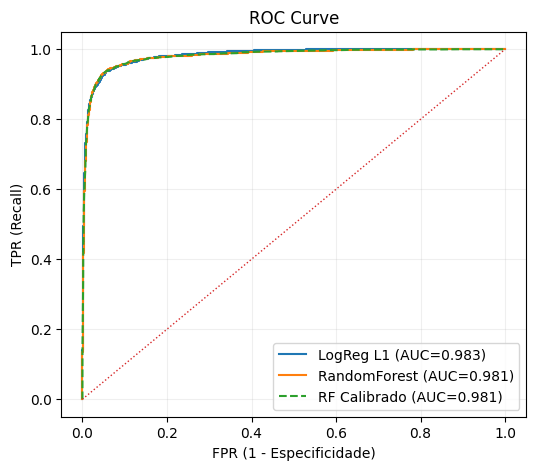

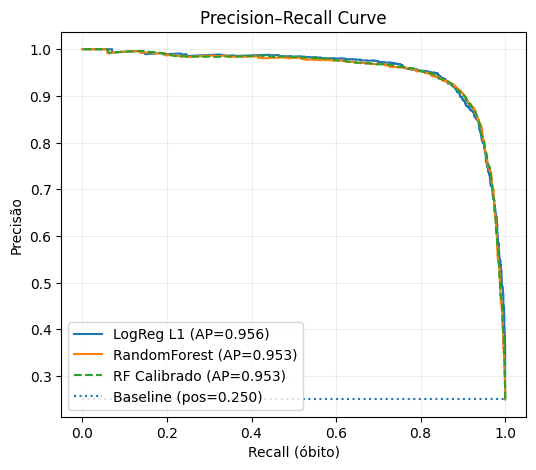

In [38]:
# CURVAS ROC e PR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

req = ['y_test','p_lr','p_rf']
missing = [v for v in req if v not in globals()]
if missing: raise RuntimeError(f"Faltam variáveis: {missing}. Rode os blocos 7–9/10 antes.")

plt.figure(figsize=(6,5))
# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, p_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, p_rf)
plt.plot(fpr_lr, tpr_lr, label=f'LogReg L1 (AUC={roc_auc_score(y_test,p_lr):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={roc_auc_score(y_test,p_rf):.3f})')

if 'p_rf_cal' in globals():
    fpr_cal, tpr_cal, _ = roc_curve(y_test, p_rf_cal)
    plt.plot(fpr_cal, tpr_cal, label=f'RF Calibrado (AUC={roc_auc_score(y_test,p_rf_cal):.3f})', linestyle='--')

plt.plot([0,1],[0,1], linestyle=':', linewidth=1)
plt.xlabel('FPR (1 - Especificidade)')
plt.ylabel('TPR (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# PR
plt.figure(figsize=(6,5))
prec_lr, rec_lr, _ = precision_recall_curve(y_test, p_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, p_rf)
plt.plot(rec_lr, prec_lr, label=f'LogReg L1 (AP={average_precision_score(y_test,p_lr):.3f})')
plt.plot(rec_rf, prec_rf, label=f'RandomForest (AP={average_precision_score(y_test,p_rf):.3f})')

if 'p_rf_cal' in globals():
    prec_cal, rec_cal, _ = precision_recall_curve(y_test, p_rf_cal)
    plt.plot(rec_cal, prec_cal, label=f'RF Calibrado (AP={average_precision_score(y_test,p_rf_cal):.3f})', linestyle='--')

# baseline da taxa de positivos
base = y_test.mean()
plt.hlines(base, 0, 1, linestyles=':', label=f'Baseline (pos={base:.3f})')
plt.xlabel('Recall (óbito)')
plt.ylabel('Precisão')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


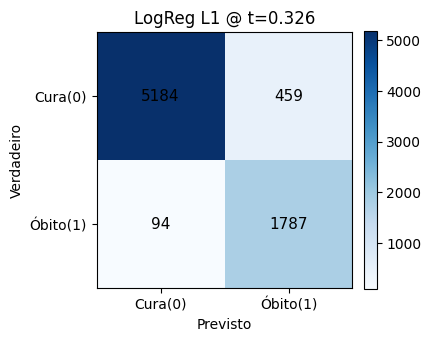

LogReg L1 @ t=0.326
              precision    recall  f1-score   support

           0     0.9822    0.9187    0.9494      5643
           1     0.7956    0.9500    0.8660      1881

    accuracy                         0.9265      7524
   macro avg     0.8889    0.9343    0.9077      7524
weighted avg     0.9356    0.9265    0.9285      7524



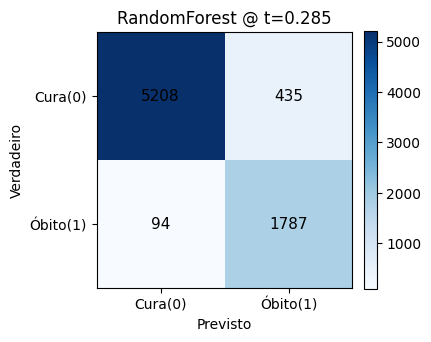

RandomForest @ t=0.285
              precision    recall  f1-score   support

           0     0.9823    0.9229    0.9517      5643
           1     0.8042    0.9500    0.8711      1881

    accuracy                         0.9297      7524
   macro avg     0.8933    0.9365    0.9114      7524
weighted avg     0.9378    0.9297    0.9315      7524



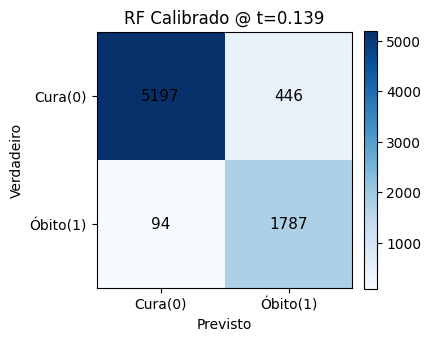

RF Calibrado @ t=0.139
              precision    recall  f1-score   support

           0     0.9822    0.9210    0.9506      5643
           1     0.8003    0.9500    0.8687      1881

    accuracy                         0.9282      7524
   macro avg     0.8913    0.9355    0.9097      7524
weighted avg     0.9367    0.9282    0.9301      7524



In [39]:
# MATRIZES DE CONFUSÃO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_cm(y_true, yhat, titulo):
    cm = confusion_matrix(y_true, yhat)
    fig, ax = plt.subplots(figsize=(4.2,3.6))
    im = ax.imshow(cm, cmap='Blues')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=11)
    ax.set_xlabel('Previsto'); ax.set_ylabel('Verdadeiro')
    ax.set_xticks([0,1]); ax.set_xticklabels(['Cura(0)','Óbito(1)'])
    ax.set_yticks([0,1]); ax.set_yticklabels(['Cura(0)','Óbito(1)'])
    ax.set_title(titulo)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    print(titulo)
    print(classification_report(y_true, yhat, digits=4))

req = ['y_test','p_lr','p_rf','t_lr','t_rf']
missing = [v for v in req if v not in globals()]
if missing: raise RuntimeError(f"Faltam variáveis: {missing}. Rode 7–12B.")

plot_cm(y_test, (p_lr>=t_lr).astype(int),  f'LogReg L1 @ t={t_lr:.3f}')
plot_cm(y_test, (p_rf>=t_rf).astype(int),  f'RandomForest @ t={t_rf:.3f}')
if 'p_rf_cal' in globals() and 't_rf_cal' in globals():
    plot_cm(y_test, (p_rf_cal>=t_rf_cal).astype(int), f'RF Calibrado @ t={t_rf_cal:.3f}')


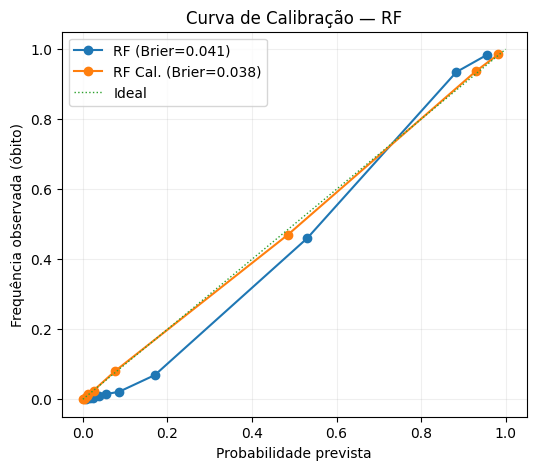

In [40]:
#CURVA DE CALIBRAÇÃO (antes vs depois)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

req = ['y_test','p_rf']
missing = [v for v in req if v not in globals()]
if missing: raise RuntimeError(f"Faltam variáveis: {missing}. Rode os blocos 8 e 15B (se quiser versão calibrada).")

plt.figure(figsize=(6,5))
prob_true_rf, prob_pred_rf = calibration_curve(y_test, p_rf, n_bins=10, strategy='quantile')
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label=f'RF (Brier={brier_score_loss(y_test,p_rf):.3f})')

if 'p_rf_cal' in globals():
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, p_rf_cal, n_bins=10, strategy='quantile')
    plt.plot(prob_pred_cal, prob_true_cal, marker='o', label=f'RF Cal. (Brier={brier_score_loss(y_test,p_rf_cal):.3f})')

plt.plot([0,1],[0,1], linestyle=':', linewidth=1, label='Ideal')
plt.xlabel('Probabilidade prevista')
plt.ylabel('Frequência observada (óbito)')
plt.title('Curva de Calibração — RF')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


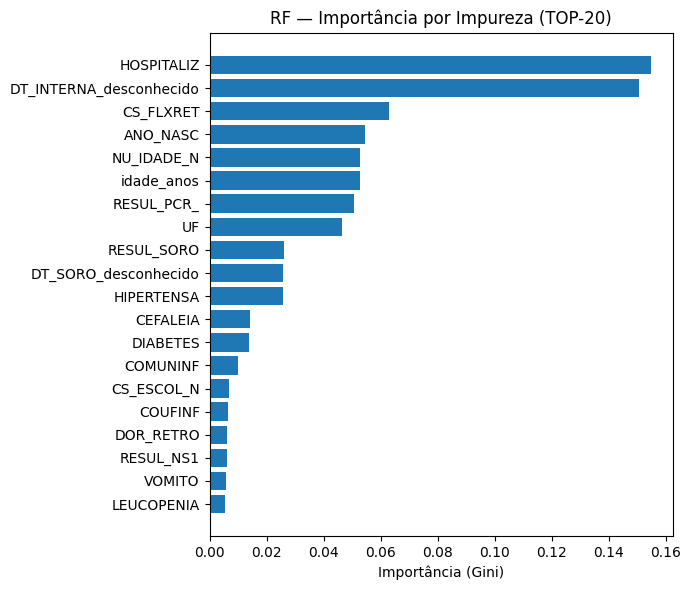

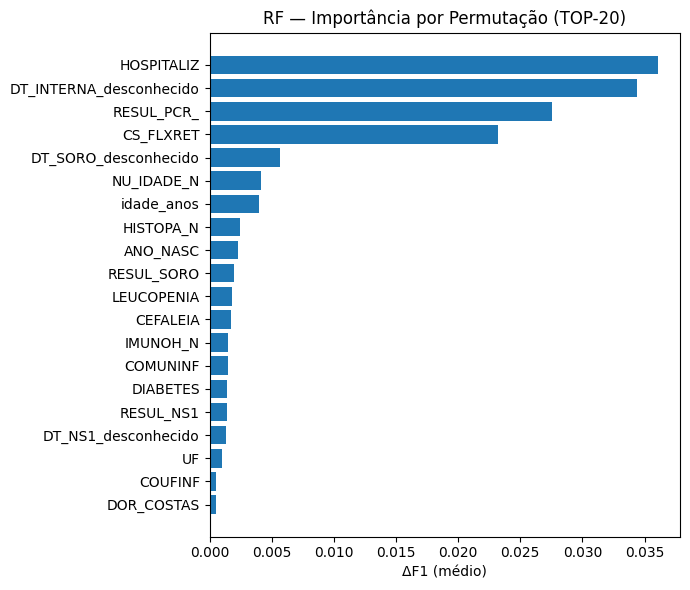

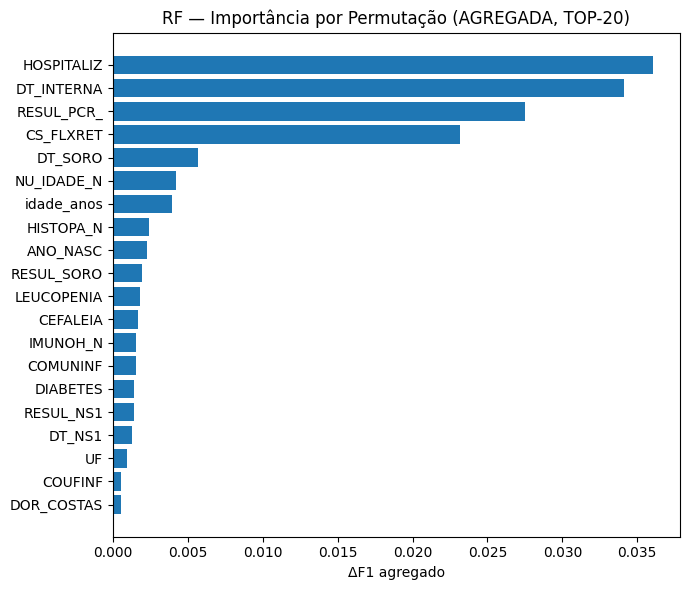

In [41]:
# IMPORTÂNCIAS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

req = ['best_rf','num_cols','cat_cols']
missing = [v for v in req if v not in globals()]
if missing: raise RuntimeError(f"Faltam variáveis: {missing}. Rode blocos 5–10.")

prep = best_rf.named_steps['prep']
try:
    ohe_names = prep.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
except Exception:
    try:
        ohe_names = prep.named_transformers_['cat'].get_feature_names_out(cat_cols)
    except Exception:
        ohe_names = [f"{c}__{i}" for i, c in enumerate(cat_cols)]
feature_names = np.array(list(num_cols) + list(ohe_names))

# (A) Impureza RF
imp = pd.Series(best_rf.named_steps['rf'].feature_importances_, index=feature_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(7,6))
plt.barh(range(len(imp)), imp.values[::-1])
plt.yticks(range(len(imp)), imp.index[::-1])
plt.title('RF — Importância por Impureza (TOP-20)')
plt.xlabel('Importância (Gini)')
plt.tight_layout(); plt.show()

# (B) Permutation
if 'imp_perm' in globals():
    ip = imp_perm.sort_values(ascending=False).head(20)
    plt.figure(figsize=(7,6))
    plt.barh(range(len(ip)), ip.values[::-1])
    plt.yticks(range(len(ip)), ip.index[::-1])
    plt.title('RF — Importância por Permutação (TOP-20)')
    plt.xlabel('ΔF1 (médio)')
    plt.tight_layout(); plt.show()
else:
    print("[Aviso] 'imp_perm' não encontrado — rode o Bloco 13C2.")

# (C) Agregado por variável original
if 'imp_perm' in globals():
    def raiz(feat):
        for col in cat_cols:
            if feat.startswith(col + "_") or feat.startswith(col + "__"):
                return col
        return feat
    agg = {}
    for feat, val in imp_perm.items():
        agg[raiz(str(feat))] = agg.get(raiz(str(feat)), 0.0) + float(val)
    agg_s = pd.Series(agg).sort_values(ascending=False).head(20)
    plt.figure(figsize=(7,6))
    plt.barh(range(len(agg_s)), agg_s.values[::-1])
    plt.yticks(range(len(agg_s)), agg_s.index[::-1])
    plt.title('RF — Importância por Permutação (AGREGADA, TOP-20)')
    plt.xlabel('ΔF1 agregado')
    plt.tight_layout(); plt.show()


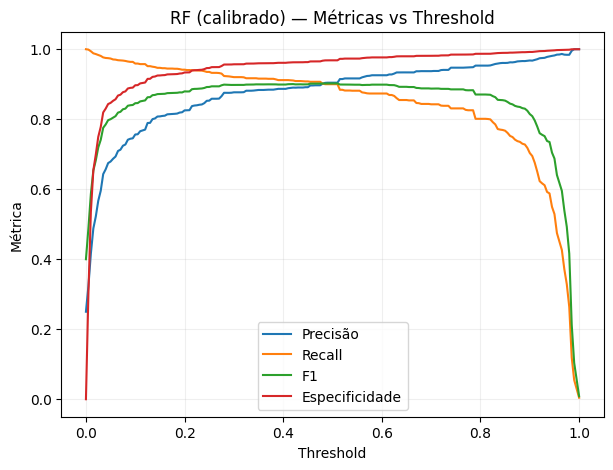

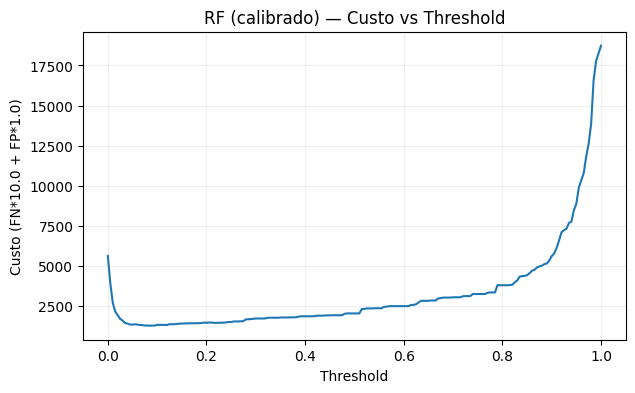

In [43]:
# CURVAS MÉTRICAS vs LIMIAR (RF)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

req = ['y_test','p_rf']
missing = [v for v in req if v not in globals()]
if missing: raise RuntimeError(f"Faltam variáveis: {missing}.")

probs = p_rf if 'p_rf_cal' not in globals() else p_rf_cal
nome = 'RF (calibrado)' if 'p_rf_cal' in globals() else 'RF'

ts = np.linspace(0,1,201)
prec, rec, f1, spec, custo = [], [], [], [], []
C_FN, C_FP = 10.0, 1.0

for t in ts:
    yhat = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    prec.append(precision_score(y_test, yhat, zero_division=0))
    rec.append(recall_score(y_test, yhat))
    f1.append(f1_score(y_test, yhat, zero_division=0))
    spec.append(tn / (tn+fp))
    custo.append(C_FN*fn + C_FP*fp)

plt.figure(figsize=(7,5))
plt.plot(ts, prec, label='Precisão')
plt.plot(ts, rec,  label='Recall')
plt.plot(ts, f1,   label='F1')
plt.plot(ts, spec, label='Especificidade')
plt.xlabel('Threshold'); plt.ylabel('Métrica')
plt.title(f'{nome} — Métricas vs Threshold')
plt.legend(); plt.grid(alpha=0.2); plt.show()

plt.figure(figsize=(7,4))
plt.plot(ts, custo)
plt.xlabel('Threshold'); plt.ylabel(f'Custo (FN*{C_FN} + FP*{C_FP})')
plt.title(f'{nome} — Custo vs Threshold')
plt.grid(alpha=0.2); plt.show()


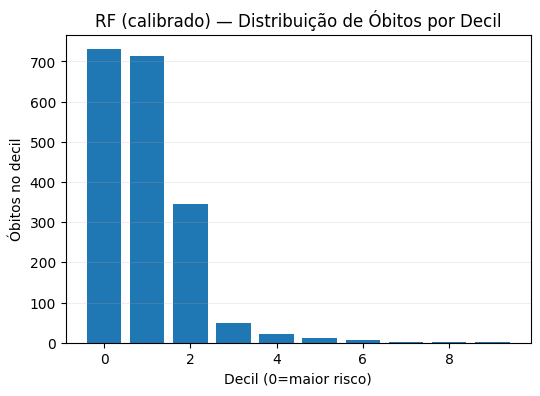

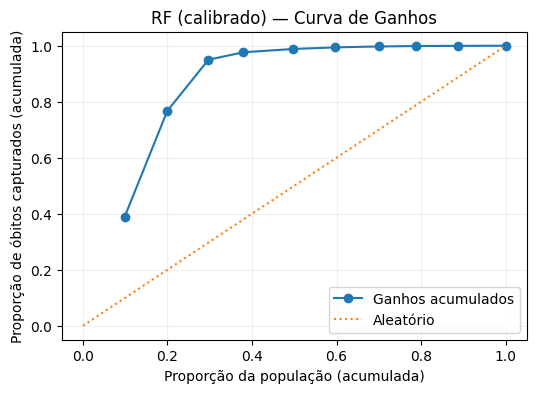

In [44]:
# LIFT / GANHOS (decis)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

req = ['y_test']
missing = [v for v in req if v not in globals()]
if missing: raise RuntimeError(f"Faltam variáveis: {missing}.")

probs = p_rf_cal if 'p_rf_cal' in globals() else p_rf
nome = 'RF (calibrado)' if 'p_rf_cal' in globals() else 'RF'

dfm = pd.DataFrame({'y': y_test.values, 'p': probs})
dfm['bucket'] = pd.qcut(dfm['p'], q=10, labels=False, duplicates='drop')
dfm['bucket'] = (dfm['bucket'].max() - dfm['bucket']).astype(int)
g = dfm.groupby('bucket').agg(n=('y','size'), eventos=('y','sum'), p_mean=('p','mean')).reset_index().sort_values('bucket')
g['perc_eventos'] = g['eventos'] / g['eventos'].sum()
g['acum_eventos'] = g['eventos'].cumsum() / g['eventos'].sum()
g['acum_pop'] = g['n'].cumsum() / g['n'].sum()
g['lift'] = g['perc_eventos'] / (1.0/len(g))

# Barras de eventos por decil
plt.figure(figsize=(6,4))
plt.bar(g['bucket'], g['eventos'])
plt.xlabel('Decil (0=maior risco)'); plt.ylabel('Óbitos no decil')
plt.title(f'{nome} — Distribuição de Óbitos por Decil'); plt.grid(axis='y', alpha=0.2)
plt.show()

# Curva de ganhos acumulados
plt.figure(figsize=(6,4))
plt.plot(g['acum_pop'], g['acum_eventos'], marker='o', label='Ganhos acumulados')
plt.plot([0,1],[0,1], linestyle=':', label='Aleatório')
plt.xlabel('Proporção da população (acumulada)')
plt.ylabel('Proporção de óbitos capturados (acumulada)')
plt.title(f'{nome} — Curva de Ganhos'); plt.legend(); plt.grid(alpha=0.2)
plt.show()
